### Image Captioning

To perform image captioning we are going to apply an approach similar to the work described in references [1],[2], and [3]. The approach applied here uses a recurrent neural network (RNN) to train a network to generate image captions. The input to the RNN is comprised of a high-level representation of an image and a caption describing it. The Microsoft Common Object in Context (MSCOCO) data set is used for this because it has many images and five captions for each one in most cases. In the previous section, we learned how to create and train a simple RNN. For this part, we will learn how to concatenate a feature vector that represents the images with its corresponding sentence and feed this into an RNN.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import inspect
import time

import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
#import reader
import collections
import os
import re
import json

import matplotlib.pyplot as plt

from scipy import ndimage
from scipy import misc
import sys
sys.path.insert(0, '/data/models/slim')

slim=tf.contrib.slim
from nets import vgg

from preprocessing import vgg_preprocessing

%matplotlib inline  
!nvidia-smi

Wed May 10 21:05:00 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.57                 Driver Version: 367.57                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 0000:00:1E.0     Off |                    0 |
| N/A   43C    P8    26W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### MSCOCO Captions 
We are going to build on our RNN example. First, we will look at the data and evaluate a single image, its captions, and feature vector.

In [2]:
TRAIN_IMAGE_PATH='/data/mscoco/train2014/'
## Read Training files
with open("/data/mscoco/captions_train2014.json") as data_file:
         data=json.load(data_file)

image_feature_vectors={}   
tf.reset_default_graph()
    
one_image=ndimage.imread(TRAIN_IMAGE_PATH+data["images"][0]['file_name'])
    #resize for vgg network
resize_img=misc.imresize(one_image,[224,224])
if len(one_image.shape)!= 3: #Check to see if the image is grayscale if True mirror colorband
    resize_img=np.asarray(np.dstack((resize_img, resize_img, resize_img)), dtype=np.uint8)

processed_image = vgg_preprocessing.preprocess_image(resize_img, 224, 224, is_training=False)
processed_images  = tf.expand_dims(processed_image, 0)      
network,endpts= vgg.vgg_16(processed_images, is_training=False)

   
init_fn = slim.assign_from_checkpoint_fn(os.path.join('/data/mscoco/vgg_16.ckpt'),slim.get_model_variables('vgg_16'))
sess = tf.Session()
init_fn(sess)
NETWORK,ENDPTS=sess.run([network,endpts])
sess.close()
print('fc7 array for a single image')
print(ENDPTS['vgg_16/fc7'][0][0][0])  

INFO:tensorflow:Restoring parameters from /data/mscoco/vgg_16.ckpt
fc7 array for a single image
[ 0.81308055  2.55591011  0.9547044  ...,  1.50954461  0.          0.        ]


u'COCO_train2014_000000057870.jpg'

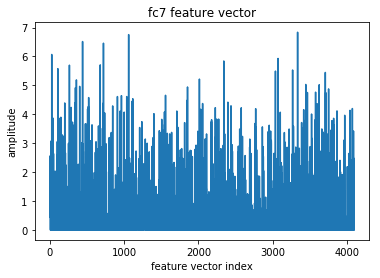

In [3]:
plt.plot(ENDPTS['vgg_16/fc7'][0][0][0])
plt.xlabel('feature vector index')
plt.ylabel('amplitude')
plt.title('fc7 feature vector')
data["images"][0]['file_name']

How can you look at feature maps from the first convolutional layer? Look here if you need a [hint](#answer1 "The output from the convolutional layer is in the form of height, width, and number of feature maps. FEATUREMAPID can be any value between 0 and the number of feature maps minus 1.").

(224, 224, 64)
input image and feature map from conv1


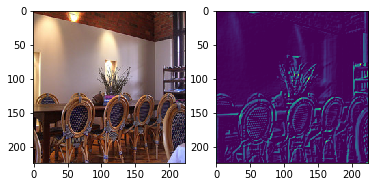

In [4]:
print(ENDPTS['vgg_16/conv1/conv1_1'][0].shape)
FEATUREMAPID=0
print('input image and feature map from conv1')
plt.subplot(1,2,1)
plt.imshow(resize_img)
plt.subplot(1,2,2)
plt.imshow(ENDPTS['vgg_16/conv1/conv1_1'][0][:,:,FEATUREMAPID])

How can you look at the response of different layers in your network? 

Next, we are going to combine the feature maps with their respective captions. Many of the images have five captions. Run the code below to view the captions for one image.

In [5]:
CaptionsForOneImage=[]
for k in range(len(data['annotations'])):
    if data['annotations'][k]['image_id']==data["images"][0]['id']:
        CaptionsForOneImage.append([data['annotations'][k]['caption'].lower()])

MSCOCO captions for a single image


[[u'a restaurant has modern wooden tables and chairs.'],
 [u'a long restaurant table with rattan rounded back chairs.'],
 [u'a long table with a plant on top of it surrounded with wooden chairs '],
 [u'a long table with a flower arrangement in the middle for meetings'],
 [u'a table is adorned with wooden chairs with blue accents.']]

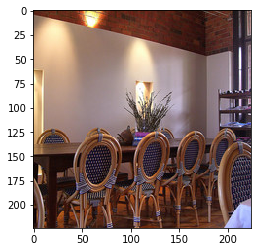

In [6]:
plt.imshow(resize_img)
print('MSCOCO captions for a single image')
CaptionsForOneImage

A file with feature vectors from 2000 of the MSCOCO images has been created. Next, you will load these and train. Please note this step can take more than 5 minutes to run.

In [7]:
example_load=np.load('/data/mscoco/train_vgg_16_fc7_2000.npy').tolist()
image_ids=example_load.keys()

In [8]:
#Create 3 lists image_id, feature maps, and captions.
image_id_key=[]
feature_maps_to_id=[]
caption_to_id=[]
for observed_image in image_ids:   
    for k in range(len(data['annotations'])):
        if data['annotations'][k]['image_id']==observed_image:
            image_id_key.append([observed_image])
            feature_maps_to_id.append(example_load[observed_image])
            caption_to_id.append(re.sub('[^A-Za-z0-9]+',' ',data['annotations'][k]['caption']).lower()) #remove punctuation 
  
print('number of images ',len(image_ids))
print('number of captions ',len(caption_to_id))

number of images  2000
number of captions  10006


In the cell above we created three lists, one for the image_id, feature map. and caption. To verify that the indices of each list are aligned, display the image id and caption for one image. 

image_id  [[196611], [196611], [196611], [196611], [196611]]
the captions for this image 
[u'a light turned on at a desk with a chair and computer ', u'a living room with the light on next to a computer desk ', u'a living room with a white chair and desk ', u'a computer on a desk next to an empty chair ', u'empty chair in front of a desk with a laptop computer and lamp ']


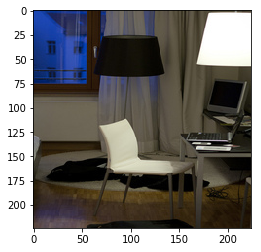

In [9]:
STRING='%012d' % image_id_key[0][0]
exp_image=ndimage.imread(TRAIN_IMAGE_PATH+'COCO_train2014_'+STRING+'.jpg')
plt.imshow(exp_image)
print('image_id ',image_id_key[:5])
print('the captions for this image ')
print(caption_to_id[:5])

In [10]:
num_steps=20
######################################################################
##Create a list of all of the sentences.
DatasetWordList=[]
for dataset_caption in caption_to_id:
        DatasetWordList+=str(dataset_caption).split()
#Determine number of distint words 
distintwords=collections.Counter(DatasetWordList)
#Order words 
count_pairs = sorted(distintwords.items(), key=lambda x: (-x[1], x[0])) #ascending order
words, occurence = list(zip(*count_pairs))
#DictionaryLength=occurence.index(4) #index for words that occur 4 times or less
words=['PAD','UNK','EOS']+list(words)#[:DictionaryLength])
word_to_id=dict(zip(words, range(len(words))))
#####################  Tokenize Sentence #######################
Tokenized=[]
for full_words in caption_to_id:
        EmbeddedSentence=[word_to_id[word] for word in full_words.split() if word in word_to_id]+[word_to_id['EOS']]
        #Pad sentences that are shorter than the number of steps 
        if len(EmbeddedSentence)<num_steps:
            b=[word_to_id['PAD']]*num_steps
            b[:len(EmbeddedSentence)]=EmbeddedSentence
        if len(EmbeddedSentence)>num_steps:
            b=EmbeddedSentence[:num_steps]
        if len(b)==EmbeddedSentence:
            b=EmeddedSentence
        #b=[word_to_id['UNK'] if x>=DictionaryLength else x for x in b] #turn all words used 4 times or less to 'UNK'
        #print(b)
        Tokenized+=[b]
        
print("Number of words in this dictionary ", len(words))

Number of words in this dictionary  4644


In [11]:
#Tokenized Sentences
Tokenized[::2000]

[[3, 180, 1030, 4, 17, 3, 334, 8, 3, 156, 9, 166, 2, 0, 0, 0, 0, 0, 0, 0],
 [3, 46, 5, 254, 771, 12, 7, 833, 45, 7, 501, 2, 0, 0, 0, 0, 0, 0, 0, 0],
 [162, 243, 44, 79, 385, 5, 161, 431, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [3, 164, 5, 19, 18, 16, 117, 3, 499, 114, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [79, 116, 6, 97, 1184, 6, 7, 1253, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [3, 56, 168, 65, 45, 602, 184, 8, 3, 2231, 52, 2, 0, 0, 0, 0, 0, 0, 0, 0]]

The next cell contains functions for queuing our data and the RNN model. What should the output for each function be? If you need a hint look [here](#answer2 "The data_queue function batches the data for us, this needs to return tokenized_caption, input_feature_map. The RNN model should return prediction before the softmax is applied and is defined as pred.").

In [16]:
def data_queue(caption_input,feature_vector,batch_size,):


    train_input_queue = tf.train.slice_input_producer(
                    [caption_input, np.asarray(feature_vector)],num_epochs=10000,
                                    shuffle=True) #False before

    ##Set our train data and label input shape for the queue

    TrainingInputs=train_input_queue[0]
    FeatureVectors=train_input_queue[1]
    TrainingInputs.set_shape([num_steps])
    FeatureVectors.set_shape([len(feature_vector[0])]) #fc7 is 4096
    min_after_dequeue=1000000
    capacity = min_after_dequeue + 3 * batch_size 
    #input_x, target_y
    tokenized_caption, input_feature_map = tf.train.batch([TrainingInputs, FeatureVectors],
                                                 batch_size=batch_size,
                                                 capacity=capacity,
                                                 num_threads=6)
    return tokenized_caption,input_feature_map
    
    

def rnn_model(Xconcat,input_keep_prob,output_keep_prob,num_layers,num_hidden):
#Create a multilayer RNN
#reuse=False for training but reuse=True for sharing
    layer_cell=[]
    for _ in range(num_layers):
        lstm_cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)
        lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,
                                          input_keep_prob=input_keep_prob,
                                          output_keep_prob=output_keep_prob)
        layer_cell.append(lstm_cell)

    cell = tf.contrib.rnn.MultiRNNCell(layer_cell, state_is_tuple=True)
    outputs, last_states = tf.contrib.rnn.static_rnn(
        cell=cell,
        dtype=tf.float32,
        inputs=tf.unstack(Xconcat))

    output_reshape=tf.reshape(outputs, [batch_size*(num_steps),num_hidden]) #[12==batch_size*num_steps,num_hidden==12]
    pred=tf.matmul(output_reshape, variables_dict["weights_mscoco"]) +variables_dict["biases_mscoco"]
    return pred

In [17]:
tf.reset_default_graph()
#######################################################################################################
# Parameters
num_hidden=2048
num_steps=num_steps
dict_length=len(words)
batch_size=4
num_layers=2
train_lr=0.00001
#######################################################################################################
TrainingInputs=Tokenized
FeatureVectors=feature_maps_to_id

## Variables ## 
# Learning rate placeholder
lr = tf.placeholder(tf.float32, shape=[])
#tf.get_variable_scope().reuse_variables()

variables_dict = {
    "weights_mscoco":tf.Variable(tf.truncated_normal([num_hidden,dict_length],
                                                     stddev=1.0,dtype=tf.float32),name="weights_mscoco"),
    "biases_mscoco": tf.Variable(tf.truncated_normal([dict_length],
                                                     stddev=1.0,dtype=tf.float32), name="biases_mscoco")}


tokenized_caption, input_feature_map=data_queue(TrainingInputs,FeatureVectors,batch_size)
mscoco_dict=words

TrainInput=tf.constant(word_to_id['PAD'],shape=[batch_size,1],dtype=tf.int32)
#Pad the beginning of our caption. The first step now only has the image feature vector. Drop the last time step 
#to timesteps to 20
TrainInput=tf.concat([tf.constant(word_to_id['PAD'],shape=[batch_size,1],dtype=tf.int32),
                      tokenized_caption],1)[:,:-1]
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), TrainInput) #[batch,num_steps,dictionary_length][2,6,7]
#ImageFeatureTensor=input_feature_map
Xconcat=tf.concat([input_feature_map+tf.zeros([num_steps,batch_size,4096]), 
                     tf.unstack(tf.to_float(X_one_hot),num_steps,1)],2)#[:num_steps,:,:]

pred=rnn_model(Xconcat,1.0,1.0,num_layers,num_hidden)


#the full caption is the target sentence
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), tokenized_caption),num_steps,1) #[batch,num_steps,dictionary_length][2,6,7]

y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])


# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))

optimizer = tf.train.MomentumOptimizer(lr,0.9)

gvs = optimizer.compute_gradients(cost,aggregation_method = tf.AggregationMethod.EXPERIMENTAL_TREE)
capped_gvs = [(tf.clip_by_value(grad, -10., 10.), var) for grad, var in gvs]
train_op=optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()

init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())    

with tf.Session() as sess:
        
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    #Load a pretrained network
    saver.restore(sess, '/data/mscoco/rnn_layermodel_iter40000')
    print('Model restored from file')
    
    for i in range(100):
        
        loss,y_pred,target_caption,_=sess.run([cost,pred,tokenized_caption,train_op],feed_dict={lr:train_lr})

        if i% 10==0:
            print("iteration: ",i, "loss: ",loss)
            
    MODEL_NAME='rnn_model_iter'+str(i)
    saver.save(sess, MODEL_NAME) 
    print('saved trained network ',MODEL_NAME)
    print("Done Training")
    coord.request_stop()
    coord.join(threads)
    sess.close() 


INFO:tensorflow:Restoring parameters from /data/mscoco/rnn_layermodel_iter40000
Model restored from file
iteration:  0 loss:  0.614859
iteration:  10 loss:  0.852881
iteration:  20 loss:  0.91307
iteration:  30 loss:  0.761541
iteration:  40 loss:  0.765284
iteration:  50 loss:  0.742418
iteration:  60 loss:  0.722067
iteration:  70 loss:  0.69909
iteration:  80 loss:  0.836048
iteration:  90 loss:  0.6169
saved trained network  rnn_model_iter99
Done Training


We can use the function below to estimate how well the network is able to predict the next word in the caption. You can evaluate a single image and its caption from the last batch using the index of the batch. If you need a hint look [here](#answer3 "if the batch_size is 4, batch_id may be any value between 0 and 3.").

##### Please note that depending on the status of the neural network at the time it was saved, incomplete, incoherent, and sometimes inappropriate captions could be generated.

Caption
['a', 'man', 'jumping', 'in', 'the', 'air', 'to', 'catch', 'a', 'frisbee', 'in', 'motion', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Predicted Words
['a', 'man', 'that', 'through', 'the', 'air', 'to', 'a', 'a', 'frisbee', 'EOS', 'his', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


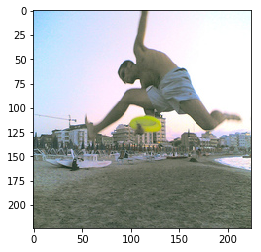

In [19]:
def show_next_predicted_word(batch_id,batch_size,id_of_image,target_caption,predicted_caption,words,PATH):
        Target=[words[ind] for ind in target_caption[batch_id]]
        Prediction_Tokenized=np.argmax(predicted_caption[batch_id::batch_size],1)
        Prediction=[words[ind] for ind in Prediction_Tokenized]
        STRING2='%012d' % id_of_image
        img=ndimage.imread(PATH+STRING2+'.jpg')
        return Target,Prediction,img,STRING2

#You can change the batch id to a number between [0 , batch_size-1]
batch_id=0
image_id_for_predicted_caption=[x for x in range(len(Tokenized)) if target_caption[batch_id].tolist()== Tokenized[x]][0]


t,p,input_img,string_out=show_next_predicted_word(batch_id,batch_size,image_id_key[image_id_for_predicted_caption][0]
                                         ,target_caption,y_pred,words,TRAIN_IMAGE_PATH+'COCO_train2014_')
print('Caption')
print(t)
print('Predicted Words')
print(p)
plt.imshow(input_img)


##### Questions
[1] Can the show_next_predicted_word function be used for deployment?

Probably not. Can you think of any reason why? Each predicted word is based on the previous ground truth word. In a deployment scenario, we will only have the feature map from our input image. 

[2] Can you load your saved network and use it to generate a caption from a validation image?

The validation images are stored in /data/mscoco/val2014. A npy file of the feature vectors is stored /data/mscoco/val_vgg_16_fc7_100.npy. For a hint on how to add this look [here](#answer4 "You can change this parameter to val_load=np.load(/data/mscoco/val_vgg_16_fc7_100.npy).tolist()").

[3] Do you need to calculate the loss or cost when only performing inference?

[4] Do you use dropout when performing inference?


In [20]:
##Load and test our test set
val_load=np.load('/data/mscoco/val_vgg_16_fc7_100.npy').tolist()
val_ids=val_load.keys()

In [21]:
#Create 3 lists image_id, feature maps, and captions.
val_id_key=[]
val_map_to_id=[]
val_caption_to_id=[]
for observed_image in val_ids:   
    val_id_key.append([observed_image])
    val_map_to_id.append(val_load[observed_image])
    
print('number of images ',len(val_ids))
print('number of captions ',len(val_map_to_id))

number of images  100
number of captions  100


The cell below will load a feature vector from one of the images in the validation data set and use it with our pretrained network to generate a caption. Use the VALDATA variable to propagate and image through our RNN and generate a caption. You also need to load the network you just created during training. Look here if you need a [hint](#answer5 "Any of the of the data points in our validation set can be used here. There are 501 captions. Any number between 0 and 501-1 can be used for the VALDATA parameter, such as VALDATA=430. The pretrained network file that you just saved is rnn_model_iter99, insert this string into saver.restore(sess,FILENAME)").

##### Please note that depending on the status of the neural network at the time it was saved, incomplete, incoherent, and sometimes inappropriate captions could be generated.

INFO:tensorflow:Restoring parameters from rnn_model_iter99
Model restored from file
predicted sentence:  ['a', 'bathroom', 'with', 'a', 'mirror', 'and', 'a', 'mirror', 'and', 'a', 'mirror', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


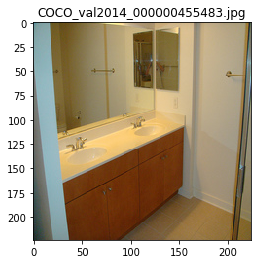

In [28]:
tf.reset_default_graph()
batch_size=1
num_steps=20
print_topn=0 #0for do not display 
printnum0f=3
#Choose a image to caption
VALDATA=54  #ValImage fc7 feature vector

variables_dict = {
    "weights_mscoco":tf.Variable(tf.truncated_normal([num_hidden,dict_length],
                                                     stddev=1.0,dtype=tf.float32),name="weights_mscoco"),
    "biases_mscoco": tf.Variable(tf.truncated_normal([dict_length],
                                                     stddev=1.0,dtype=tf.float32), name="biases_mscoco")}


StartCaption=np.zeros([batch_size,num_steps],dtype=np.int32).tolist()

CaptionPlaceHolder = tf.placeholder(dtype=tf.int32, shape=(batch_size , num_steps))

ValFeatureMap=val_map_to_id[VALDATA]
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), CaptionPlaceHolder) #[batch,num_steps,dictionary_length][2,6,7]
    #ImageFeatureTensor=input_feature_map
Xconcat=tf.concat([ValFeatureMap+tf.zeros([num_steps,batch_size,4096]), 
                            tf.unstack(tf.to_float(X_one_hot),num_steps,1)],2)#[:num_steps,:,:]

pred=rnn_model(Xconcat,1.0,1.0,num_layers,num_hidden)
pred=tf.nn.softmax(pred)
saver = tf.train.Saver()

init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())    

with tf.Session() as sess:
        
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    #Load a pretrained network
    saver.restore(sess, 'rnn_model_iter99')
    print('Model restored from file')
    for i in range(num_steps-1):
        predict_next_word=sess.run([pred],feed_dict={CaptionPlaceHolder:StartCaption})
        INDEX=np.argmax(predict_next_word[0][i])
        StartCaption[0][i+1]=INDEX
        ##Post N most probable next words at each step
        if print_topn !=0:
            print("Top ",str(printnum0f), "predictions for the", str(i+1), "word in the predicted caption" )
            result_args = np.argsort(predict_next_word[0][i])[-printnum0f:][::-1]
            NextWord=[words[x] for x in result_args]
            print(NextWord)
        
    coord.request_stop()
    coord.join(threads)
    sess.close() 

STRING2='%012d' % val_id_key[VALDATA][0]
img=ndimage.imread('/data/mscoco/val2014/COCO_val2014_'+STRING2+'.jpg')
plt.imshow(img)
plt.title('COCO_val2014_'+STRING2+'.jpg')
PredictedCaption=[words[x] for x in StartCaption[0]]
print("predicted sentence: ",PredictedCaption[1:])

In [ ]:
#Free our GPU memory before proceeding to the next part of the lab
import os
os._exit(00)

## References 

[1] Donahue, J, et al. "Long-term recurrent convolutional networks for visual recognition and description."     Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.

[2]Vinyals, Oriol, et al. "Show and tell: Lessons learned from the 2015 mscoco image captioning challenge." IEEE transactions on pattern analysis and machine intelligence 39.4 (2017): 652-663.

[3] TensorFlow Show and Tell:A Neural Image Caption Generator [example] (https://github.com/tensorflow/models/tree/master/im2txt)

[4] Karapthy, A. [NeuralTalk2](https://github.com/karpathy/neuraltalk2)

[5]Lin, Tsung-Yi, et al. "Microsoft coco: Common objects in context." European Conference on Computer Vision. Springer International Publishing, 2014.